### define global metrics (for a set of GFA):
    - distribution of number of nodes
    - distribution of number of edges
    - distribution of lengths (num characters) of GFAs
### define plots based on other variables: 
    - percentaje of identical columns
    For one MSA,
        - distribution of lengths of maximal blocks
        - distribution of lengths of blocks in the input set
        - distribution of lengths of blocks in the optimal solution
        - use as lower bound the optimal construction (sum all different characters of each column), this is the best possible
        and is related to the SICS problem defined in the manuscript
        
    - Usage ratio: given a variation graph $G=(V,A,W,\lambda)$ (V:vertices, A:edges, W:paths, $\lambda: V\mapsto \Sigma^*$: label function), we define the total usage ratio (of the paths w.r.t the graph) as 
    $$\sum_{p \in W} |\lambda(p)| / \sum_{v \in V} |\lambda(v)|$$

    This is the ratio between the total number of characters used by all paths and the total length of the graph, defined as the usage ratio. 

    The average usage ratio correspond to 
    
    $$\dfrac{1}{|W|}\sum_{p \in W} \lambda(p) / \sum_{v \in V} \lambda(v)$$


    - Jaccard distance between nodes used by each path and the total set of nodes. this should give an idea of the \% of the graph that is being used by the sequence. 

(include as variable of interest to analyze with it, the \% of identical columns in the MSA)

In [35]:
# # Filter MSAs with at least 2 different rows
# import pandas as pd 

# msas_data = pd.read_csv("../info-all-msas/analysis-msa/stats_msas.tsv", sep="\t", index_col=False)
# filtered_msas = [ path + "\n" for path in msas_data.query("n_unique_seqs > 1")["path_msa"] ]

# with open("../info-all-msas/analysis-msa/filtered_msas.txt","w") as fp:
#     fp.writelines( 
#         filtered_msas        
#     )

In [36]:
"Read a graph in gfa format and compute some stats"
from typing import Union
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

class GFAStats:

    def __call__(self, path_gfa: Union[str,Path]):
        nodes, edges, paths = self.load_graph(path_gfa)
        len_graph = sum([len(label) for label in nodes.values()])

        len_paths = sum([ len(nodes[idnode]) for path in paths for idnode in path]) if paths else None
        num_paths = len(paths)

        # stat by string: paths vs graph    
        total_str_usage_ratio = len_paths / len_graph if paths else None
        avg_str_usage_ratio   = total_str_usage_ratio / num_paths  if paths else None

        # stat by nodes: paths vs graph
        total_node_usage_ratio = sum([len(path) for path in paths]) / len(nodes) if paths else None # paths are list of nodes
        avg_node_usage_ratio   = total_node_usage_ratio / num_paths if paths else None

        return dict(
                nodes=len(nodes), 
                edges=len(edges), 
                len_graph=len_graph,
                len_paths=len_paths,
                num_paths=num_paths,
                total_str_usage_ratio=total_str_usage_ratio,
                avg_str_usage_ratio=avg_str_usage_ratio, # avg percentage of utilization of the graph by a path
                total_node_usage_ratio=total_node_usage_ratio,
                avg_node_usage_ratio=avg_node_usage_ratio,
                )
        
    def load_graph(self, path_gfa):
        nodes = dict()
        edges = list()
        paths = list()
        with open(path_gfa, "r") as fp:
            for line in fp.readlines():
                line = line.replace("\n","")
                line_split = line.split("\t")

                # nodes
                if line_split[0] == "S": 
                    id_node = line_split[1]
                    label   = line_split[2]
                    nodes[id_node] = label
                # edges
                elif line_split[0] == "L":
                    _, idnode1, _, idnode2, _, _ = line_split
                    edges.append((idnode1,idnode2))

                # paths
                elif line_split[0] == "P":
                    _, _, path, _ = line_split
                    path_nodes = path.replace("\n","").strip().split(",")
                    paths.append([node.replace("+","") for node in path_nodes])
        return nodes, edges, paths

    def length_graph(self, nodes):
        return sum(nodes.values())

In [52]:
def compute_stats(path_gfas):
    gfastats = GFAStats()
    stats = dict()
    for path_gfa in Path(path_gfas).rglob("*.gfa"):
        stats[path_gfa] = gfastats(path_gfa)

    stats_df = pd.DataFrame.from_dict(stats).T

    return stats_df

In [53]:
# params
path_pb = "../output-100msas/gfa-unchop/"
path_mprg = "../output-100msas/output-pandora/"
path_stats_msas = "../output-100msas/analysis-msa/stats_msas.tsv"

### MSAs

In [54]:
stats_msas = pd.read_csv(path_stats_msas, sep="\t", index_col=False)
stats_msas["name_msa"] = stats_msas["path_msa"].apply(lambda p: Path(p).stem)
stats_msas

,timestamp,path_msa,n_seqs,n_unique_seqs,n_identical_cols,n_cols,perc_identical_cols,name_msa
0,Sun Jan 22 16:18:49 2023,100msas/GC00008006.fa,4,3,213,219,97.26,GC00008006
1,Sun Jan 22 16:18:49 2023,100msas/GC00007322.fa,6,2,203,204,99.51,GC00007322
2,Sun Jan 22 16:18:49 2023,100msas/GC00008900.fa,2,2,238,243,97.94,GC00008900
3,Sun Jan 22 16:18:49 2023,100msas/GC00003991_2.fa,49,6,148,189,78.31,GC00003991_2
4,Sun Jan 22 16:18:49 2023,100msas/GC00003746_1.fa,7,2,1254,1263,99.29,GC00003746_1
...,...,...,...,...,...,...,...,...
95,Sun Jan 22 16:18:52 2023,100msas/GC00000016_29.fa,216,49,2367,2514,94.15,GC00000016_29
96,Sun Jan 22 16:18:52 2023,100msas/GC00000281_3.fa,180,42,1071,1236,86.65,GC00000281_3
97,Sun Jan 22 16:18:52 2023,100msas/GC00000546_3.fa,302,68,1033,1161,88.98,GC00000546_3
98,Sun Jan 22 16:18:52 2023,100msas/GC00000016_37.fa,264,87,2359,2814,83.83,GC00000016_37


## Pangeblocks

[Text(0.5, 1.0, 'pangeblocks: Histogram average node usage ratio')]

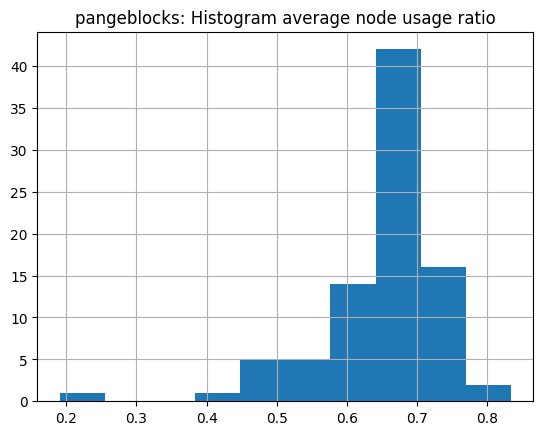

In [55]:
# pangeblocks
stats_pb = compute_stats(path_pb)
stats_pb["name_msa"] = [Path(p).stem for p in stats_pb.index ]
ax = stats_pb["avg_node_usage_ratio"].hist()
ax.set(title="pangeblocks: Histogram average node usage ratio")

In [56]:
# merged pangeblocks stats and msa stats
stats_pb_merged = pd.merge(left=stats_pb, right=stats_msas[["name_msa","perc_identical_cols"]], how="left", on="name_msa")

In [57]:
stats_pb_merged.corr()

/tmp/ipykernel_1309623/591259110.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  stats_pb_merged.corr()


,nodes,edges,len_graph,len_paths,num_paths,total_str_usage_ratio,avg_str_usage_ratio,total_node_usage_ratio,avg_node_usage_ratio,perc_identical_cols
nodes,1.000000,0.999576,0.613538,0.297536,-0.046187,-0.059050,-0.247791,-0.056911,-0.296100,-0.593017
edges,0.999576,1.000000,0.614556,0.293320,-0.046387,-0.060562,-0.262990,-0.057789,-0.307753,-0.595969
len_graph,0.613538,0.614556,1.000000,0.106273,-0.267941,-0.266727,-0.131495,-0.272875,-0.227869,-0.045329
len_paths,0.297536,0.293320,0.106273,1.000000,0.745972,0.741891,0.023634,0.737888,-0.092349,-0.224633
num_paths,-0.046187,-0.046387,-0.267941,0.745972,1.000000,0.987810,-0.001384,0.996010,-0.086775,-0.153939
total_str_usage_ratio,-0.059050,-0.060562,-0.266727,0.741891,0.987810,1.000000,0.103827,0.995609,-0.007265,-0.116876
avg_str_usage_ratio,-0.247791,-0.262990,-0.131495,0.023634,-0.001384,0.103827,1.000000,0.050818,0.814232,0.344706
total_node_usage_ratio,-0.056911,-0.057789,-0.272875,0.737888,0.996010,0.995609,0.050818,1.000000,-0.037448,-0.130531
avg_node_usage_ratio,-0.296100,-0.307753,-0.227869,-0.092349,-0.086775,-0.007265,0.814232,-0.037448,1.000000,0.374267
perc_identical_cols,-0.593017,-0.595969,-0.045329,-0.224633,-0.153939,-0.116876,0.344706,-0.130531,0.374267,1.000000


<AxesSubplot: >

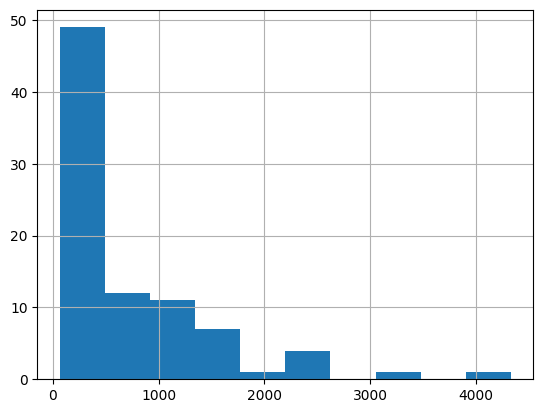

In [43]:
stats_pb["len_graph"].hist()

In [44]:
stats_pb.query("avg_str_usage_ratio < 0.3")

,nodes,edges,len_graph,len_paths,num_paths,total_str_usage_ratio,avg_str_usage_ratio,total_node_usage_ratio,avg_node_usage_ratio,name_msa
../output-100msas/gfa-unchop/Cluster_4471.gfa,36.0,66.0,1757.0,3571.0,16.0,2.032442,0.127028,3.055556,0.190972,Cluster_4471
../output-100msas/gfa-unchop/Cluster_5186.gfa,34.0,50.0,596.0,5248.0,42.0,8.805369,0.209652,20.852941,0.496499,Cluster_5186


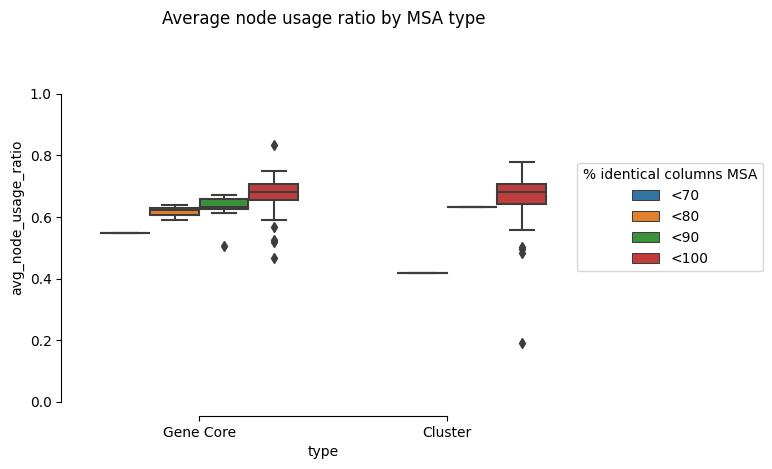

In [45]:
# bins percentage identical columns
vbins=[0,70,80,90,100]
lbins = [f"<{bin}" for bin in vbins[1:]]
stats_pb_merged["b_perc_identical_cols"]=pd.cut(stats_pb_merged["perc_identical_cols"], bins=vbins, labels=lbins)
stats_pb_merged["type"] = stats_pb_merged["name_msa"].apply(lambda p: "Cluster" if p.startswith("Cluster") else "Gene Core")

ax=sns.boxplot(data=stats_pb_merged, x="type",y="avg_node_usage_ratio", hue="b_perc_identical_cols")
ax.set(ylim=(0.,1.2))
ax.set(title="Average node usage ratio by MSA type")
ax.legend(loc="center right", fancybox=True, title="% identical columns MSA", bbox_to_anchor=(1.4,0.5) )
sns.despine(offset=10, trim=True)

### `make_prg`

[Text(0.5, 1.0, 'make_prg: Histogram length of the graph')]

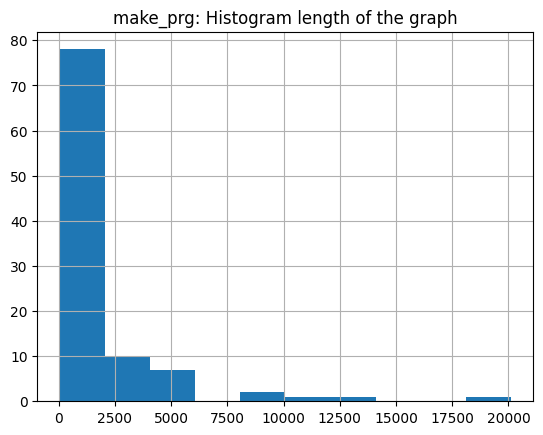

In [46]:
stats_mprg = compute_stats(path_mprg)
stats_mprg["name_msa"] = [Path(p).stem for p in stats_mprg.index ]
ax = stats_mprg["len_graph"].hist()
ax.set(title="make_prg: Histogram length of the graph")

In [47]:
stats_mprg_merged = pd.merge(left=stats_mprg, right=stats_msas[["name_msa","perc_identical_cols"]], how="left", on="name_msa")
stats_mprg_merged.describe()

,nodes,edges,len_graph,len_paths,num_paths,total_str_usage_ratio,avg_str_usage_ratio,total_node_usage_ratio,avg_node_usage_ratio,perc_identical_cols
count,100.000000,100.000000,100.000000,0.0,100.0,0.0,0.0,0.0,0.0,100.0000
mean,95.840000,134.420000,1660.990000,NaN,0.0,NaN,NaN,NaN,NaN,92.9814
std,165.000993,233.198107,2916.022109,NaN,0.0,NaN,NaN,NaN,NaN,7.5243
min,4.000000,4.000000,61.000000,NaN,0.0,NaN,NaN,NaN,NaN,65.9700
25%,10.000000,12.000000,236.500000,NaN,0.0,NaN,NaN,NaN,NaN,89.2975
50%,28.000000,37.000000,596.500000,NaN,0.0,NaN,NaN,NaN,NaN,95.4800
75%,113.250000,168.500000,1634.000000,NaN,0.0,NaN,NaN,NaN,NaN,98.8750
max,1186.000000,1640.000000,20103.000000,NaN,0.0,NaN,NaN,NaN,NaN,100.0000


### Correlation between GFA stats `Pangeblock`

In [59]:
pb_corr = stats_pb_merged.corr()
pb_corr

/tmp/ipykernel_1309623/2575169311.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pb_corr = stats_pb_merged.corr()


,nodes,edges,len_graph,len_paths,num_paths,total_str_usage_ratio,avg_str_usage_ratio,total_node_usage_ratio,avg_node_usage_ratio,perc_identical_cols
nodes,1.000000,0.999576,0.613538,0.297536,-0.046187,-0.059050,-0.247791,-0.056911,-0.296100,-0.593017
edges,0.999576,1.000000,0.614556,0.293320,-0.046387,-0.060562,-0.262990,-0.057789,-0.307753,-0.595969
len_graph,0.613538,0.614556,1.000000,0.106273,-0.267941,-0.266727,-0.131495,-0.272875,-0.227869,-0.045329
len_paths,0.297536,0.293320,0.106273,1.000000,0.745972,0.741891,0.023634,0.737888,-0.092349,-0.224633
num_paths,-0.046187,-0.046387,-0.267941,0.745972,1.000000,0.987810,-0.001384,0.996010,-0.086775,-0.153939
total_str_usage_ratio,-0.059050,-0.060562,-0.266727,0.741891,0.987810,1.000000,0.103827,0.995609,-0.007265,-0.116876
avg_str_usage_ratio,-0.247791,-0.262990,-0.131495,0.023634,-0.001384,0.103827,1.000000,0.050818,0.814232,0.344706
total_node_usage_ratio,-0.056911,-0.057789,-0.272875,0.737888,0.996010,0.995609,0.050818,1.000000,-0.037448,-0.130531
avg_node_usage_ratio,-0.296100,-0.307753,-0.227869,-0.092349,-0.086775,-0.007265,0.814232,-0.037448,1.000000,0.374267
perc_identical_cols,-0.593017,-0.595969,-0.045329,-0.224633,-0.153939,-0.116876,0.344706,-0.130531,0.374267,1.000000


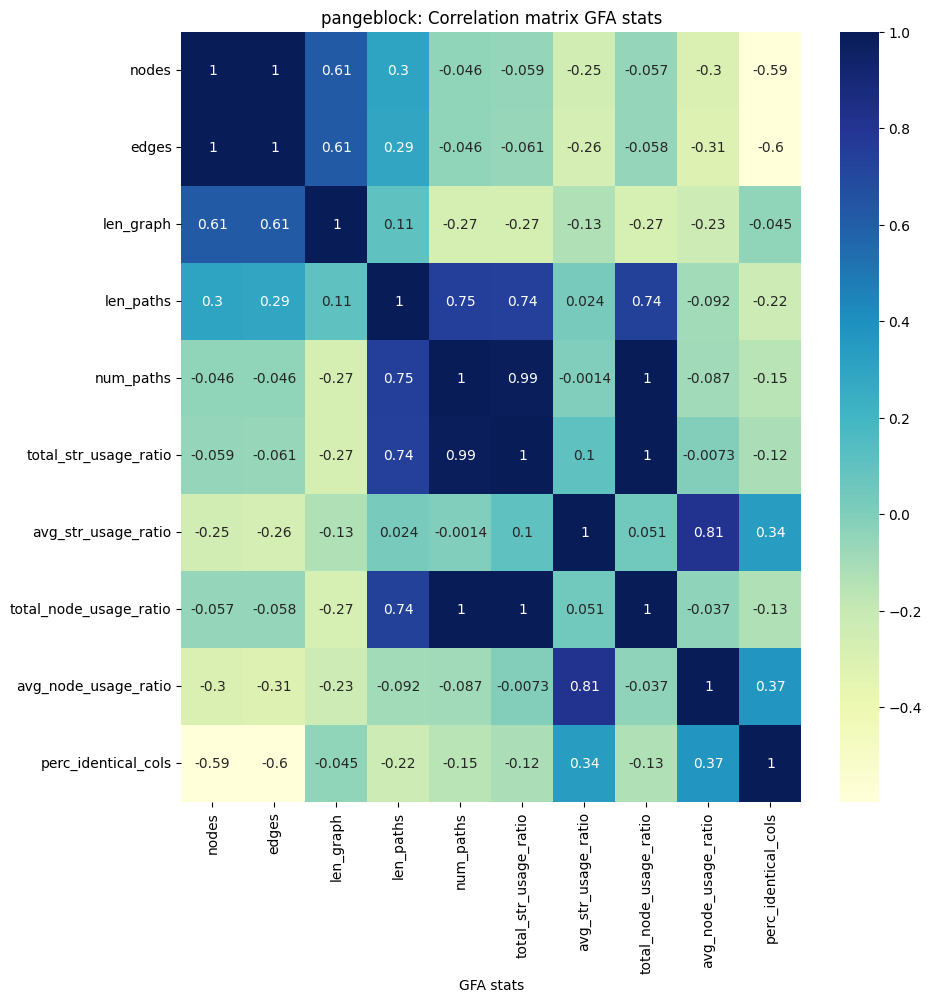

In [60]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(pb_corr, annot=True, cmap=plt.cm.YlGnBu)
plt.xlabel('GFA stats')
ax.set(title="pangeblock: Correlation matrix GFA stats")
plt.show()

### Correlation between GFA stats `make_prg`

In [61]:
mprg_corr = stats_mprg_merged.corr()
mprg_corr

/tmp/ipykernel_1309623/3312419249.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mprg_corr = stats_mprg_merged.corr()


,nodes,edges,len_graph,len_paths,num_paths,total_str_usage_ratio,avg_str_usage_ratio,total_node_usage_ratio,avg_node_usage_ratio,perc_identical_cols
nodes,1.000000,0.998813,0.877272,NaN,NaN,NaN,NaN,NaN,NaN,-0.469594
edges,0.998813,1.000000,0.868826,NaN,NaN,NaN,NaN,NaN,NaN,-0.482156
len_graph,0.877272,0.868826,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,-0.345681
len_paths,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_paths,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_str_usage_ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_str_usage_ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_node_usage_ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_node_usage_ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
perc_identical_cols,-0.469594,-0.482156,-0.345681,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


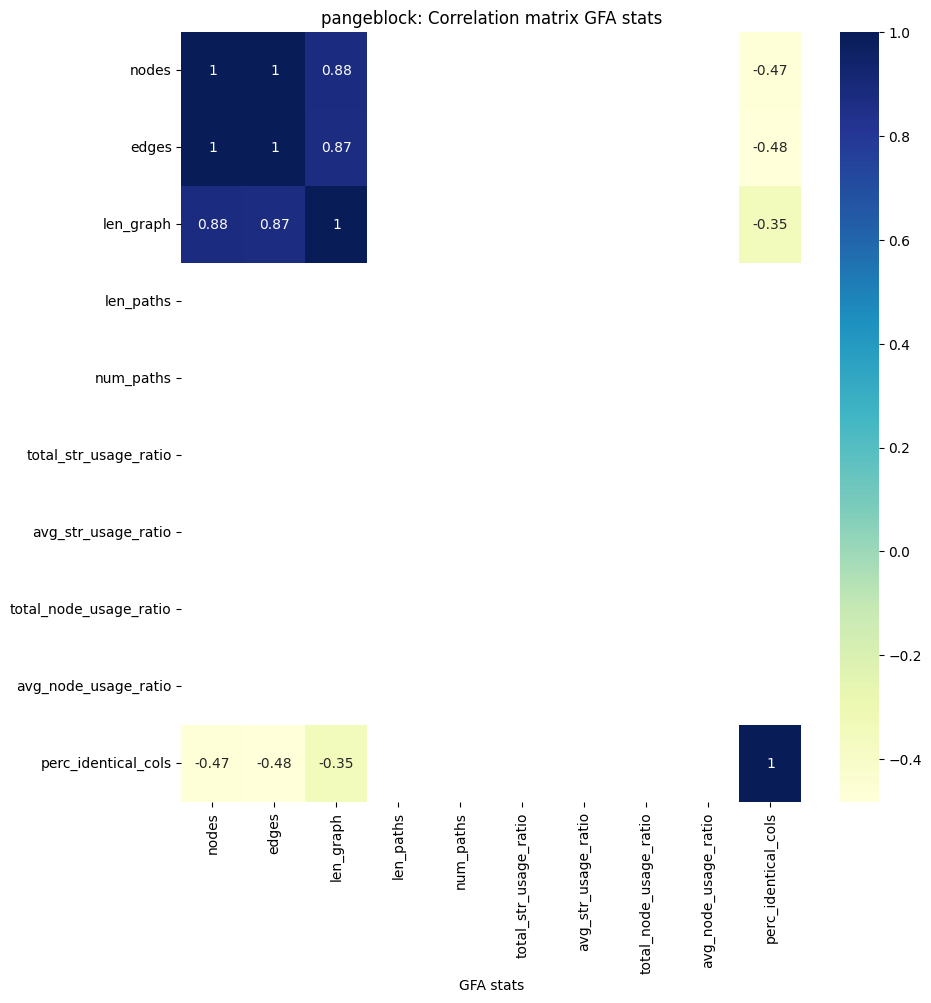

In [62]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(mprg_corr, annot=True, cmap=plt.cm.YlGnBu)
plt.xlabel('GFA stats')
ax.set(title="pangeblock: Correlation matrix GFA stats")
plt.show()